In [1]:
import torch 
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import init
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time

/opt/conda/envs/SAM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 定义一个通用的FFN类
class FFN(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens_list):
        super(FFN, self).__init__()
        layers = []
        input_dim = num_inputs
        for num_hiddens in num_hiddens_list:
            layers.append(nn.Linear(input_dim, num_hiddens))
            layers.append(nn.ReLU())
            input_dim = num_hiddens
        layers.append(nn.Linear(input_dim, num_outputs))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [3]:
# 定义准确率函数
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [4]:
# 训练和评估函数
def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device):
    # 记录训练时间
    start_time = time.time()
    print('Training on: ', device)
    train_loss_list, train_accuracy_list = [], []
    test_loss_list, test_accuracy_list = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_accuracy = 0, 0
        for X, y in train_loader:
            X, y = X.view(-1, 28*28).to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += accuracy(pred, y)
        
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        
        model.eval()
        test_loss, test_accuracy = 0, 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.view(-1, 28*28).to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                test_accuracy += accuracy(pred, y)
        
        test_loss /= len(test_loader)
        test_accuracy /= len(test_loader)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        
    print('Training time: ', time.time()-start_time)
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

# 可视化结果
def show(train_loss_list, test_loss_list, train_accuracy_list=None, test_accuracy_list=None):
    plt.figure(figsize=(12, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(test_loss_list, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
     
    if train_accuracy_list != None:
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy_list, label='Train Accuracy')
        plt.plot(test_accuracy_list, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy over Epochs')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [5]:
# 加载数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

50890
Training on:  cuda
Epoch [1/60], Train Loss: 0.7378, Train Accuracy: 0.8219, Test Loss: 0.3555, Test Accuracy: 0.9031
Epoch [2/60], Train Loss: 0.3383, Train Accuracy: 0.9046, Test Loss: 0.3001, Test Accuracy: 0.9151
Epoch [3/60], Train Loss: 0.2930, Train Accuracy: 0.9168, Test Loss: 0.2634, Test Accuracy: 0.9255
Epoch [4/60], Train Loss: 0.2631, Train Accuracy: 0.9247, Test Loss: 0.2402, Test Accuracy: 0.9310
Epoch [5/60], Train Loss: 0.2395, Train Accuracy: 0.9319, Test Loss: 0.2187, Test Accuracy: 0.9366
Epoch [6/60], Train Loss: 0.2192, Train Accuracy: 0.9381, Test Loss: 0.2047, Test Accuracy: 0.9408
Epoch [7/60], Train Loss: 0.2027, Train Accuracy: 0.9425, Test Loss: 0.1881, Test Accuracy: 0.9450
Epoch [8/60], Train Loss: 0.1879, Train Accuracy: 0.9464, Test Loss: 0.1768, Test Accuracy: 0.9488
Epoch [9/60], Train Loss: 0.1755, Train Accuracy: 0.9500, Test Loss: 0.1689, Test Accuracy: 0.9512
Epoch [10/60], Train Loss: 0.1648, Train Accuracy: 0.9527, Test Loss: 0.1576, Test A

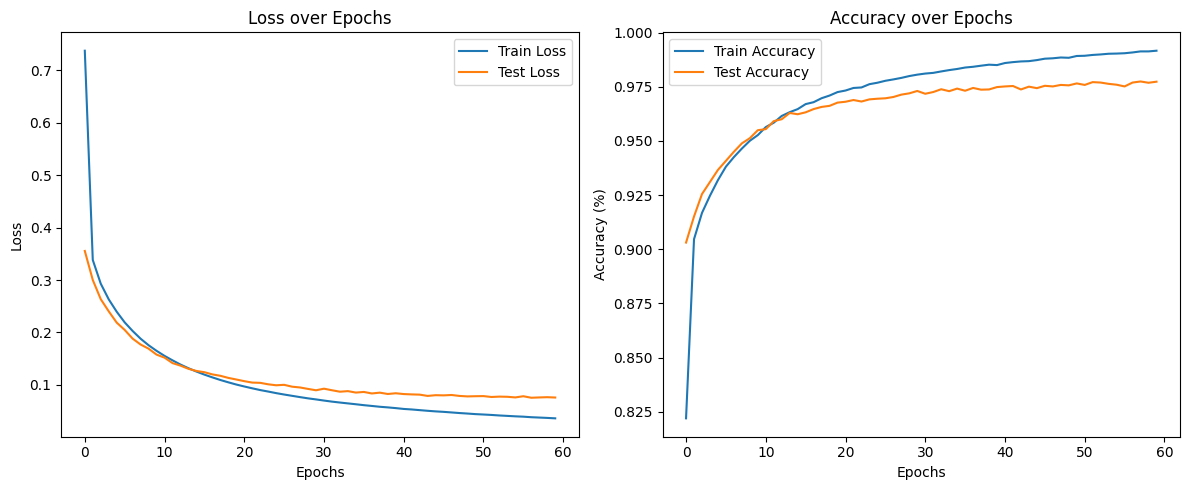

In [6]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens_list=[64]).to(device)
# 模型参数量
print(sum(p.numel() for p in model.parameters()))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_64, train_accuracy_list_64, test_loss_list_64, test_accuracy_list_64 = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)

show(train_loss_list_64, test_loss_list_64, train_accuracy_list_64, test_accuracy_list_64)

cuda
101770
Training on:  cuda
Epoch [1/60], Train Loss: 0.7195, Train Accuracy: 0.8321, Test Loss: 0.3634, Test Accuracy: 0.8982
Epoch [2/60], Train Loss: 0.3377, Train Accuracy: 0.9039, Test Loss: 0.2979, Test Accuracy: 0.9155
Epoch [3/60], Train Loss: 0.2895, Train Accuracy: 0.9175, Test Loss: 0.2595, Test Accuracy: 0.9271
Epoch [4/60], Train Loss: 0.2584, Train Accuracy: 0.9264, Test Loss: 0.2386, Test Accuracy: 0.9321
Epoch [5/60], Train Loss: 0.2330, Train Accuracy: 0.9340, Test Loss: 0.2172, Test Accuracy: 0.9389
Epoch [6/60], Train Loss: 0.2116, Train Accuracy: 0.9409, Test Loss: 0.1988, Test Accuracy: 0.9435
Epoch [7/60], Train Loss: 0.1933, Train Accuracy: 0.9458, Test Loss: 0.1822, Test Accuracy: 0.9476
Epoch [8/60], Train Loss: 0.1781, Train Accuracy: 0.9501, Test Loss: 0.1698, Test Accuracy: 0.9499
Epoch [9/60], Train Loss: 0.1643, Train Accuracy: 0.9543, Test Loss: 0.1598, Test Accuracy: 0.9541
Epoch [10/60], Train Loss: 0.1526, Train Accuracy: 0.9572, Test Loss: 0.1509, 

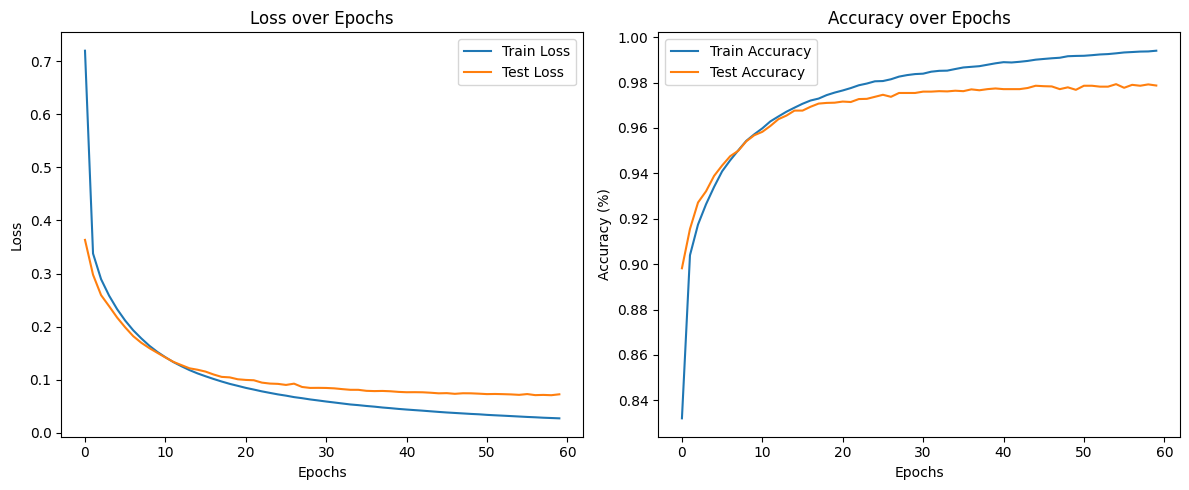

In [7]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens_list=[128]).to(device)
# 模型参数量
print(sum(p.numel() for p in model.parameters()))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_128, train_accuracy_list_128, test_loss_list_128, test_accuracy_list_128 = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)

show(train_loss_list_128, test_loss_list_128, train_accuracy_list_128, test_accuracy_list_128)

cuda
203530
Training on:  cuda
Epoch [1/60], Train Loss: 0.7232, Train Accuracy: 0.8281, Test Loss: 0.3514, Test Accuracy: 0.9026
Epoch [2/60], Train Loss: 0.3331, Train Accuracy: 0.9060, Test Loss: 0.2894, Test Accuracy: 0.9196
Epoch [3/60], Train Loss: 0.2845, Train Accuracy: 0.9198, Test Loss: 0.2605, Test Accuracy: 0.9259
Epoch [4/60], Train Loss: 0.2520, Train Accuracy: 0.9290, Test Loss: 0.2293, Test Accuracy: 0.9353
Epoch [5/60], Train Loss: 0.2260, Train Accuracy: 0.9366, Test Loss: 0.2103, Test Accuracy: 0.9391
Epoch [6/60], Train Loss: 0.2049, Train Accuracy: 0.9429, Test Loss: 0.1904, Test Accuracy: 0.9453
Epoch [7/60], Train Loss: 0.1870, Train Accuracy: 0.9477, Test Loss: 0.1771, Test Accuracy: 0.9477
Epoch [8/60], Train Loss: 0.1717, Train Accuracy: 0.9514, Test Loss: 0.1633, Test Accuracy: 0.9519
Epoch [9/60], Train Loss: 0.1583, Train Accuracy: 0.9554, Test Loss: 0.1541, Test Accuracy: 0.9552
Epoch [10/60], Train Loss: 0.1468, Train Accuracy: 0.9588, Test Loss: 0.1434, 

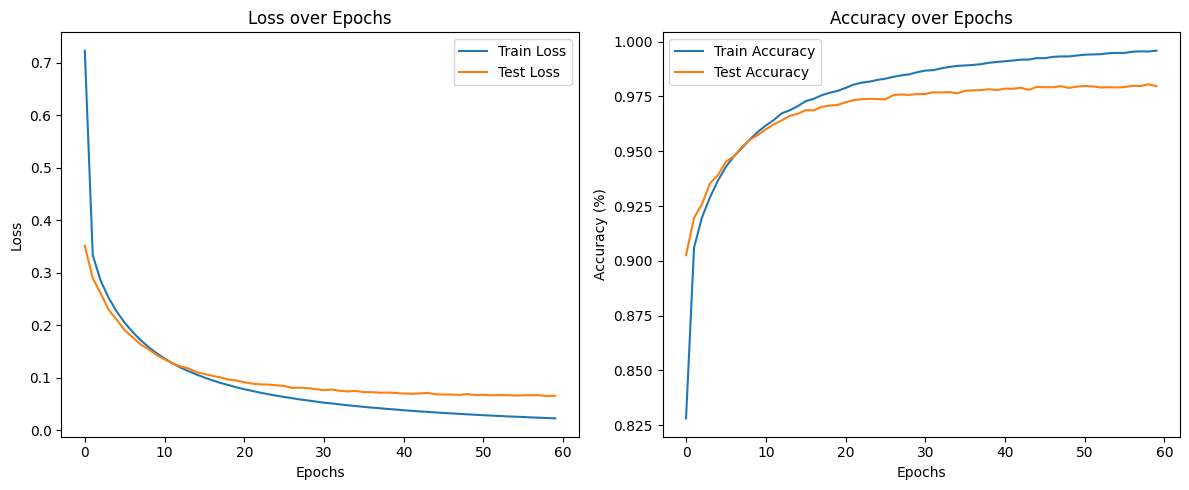

In [8]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens_list=[256]).to(device)
# 模型参数量
print(sum(p.numel() for p in model.parameters()))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_256, train_accuracy_list_256, test_loss_list_256, test_accuracy_list_256 = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)

show(train_loss_list_256, test_loss_list_256, train_accuracy_list_256, test_accuracy_list_256)

cuda
55050
Training on:  cuda
Epoch [1/60], Train Loss: 0.9129, Train Accuracy: 0.7460, Test Loss: 0.3752, Test Accuracy: 0.8881
Epoch [2/60], Train Loss: 0.3396, Train Accuracy: 0.9016, Test Loss: 0.3001, Test Accuracy: 0.9124
Epoch [3/60], Train Loss: 0.2742, Train Accuracy: 0.9213, Test Loss: 0.2501, Test Accuracy: 0.9259


Epoch [4/60], Train Loss: 0.2303, Train Accuracy: 0.9336, Test Loss: 0.2045, Test Accuracy: 0.9391
Epoch [5/60], Train Loss: 0.1979, Train Accuracy: 0.9433, Test Loss: 0.1854, Test Accuracy: 0.9465
Epoch [6/60], Train Loss: 0.1744, Train Accuracy: 0.9501, Test Loss: 0.1607, Test Accuracy: 0.9535
Epoch [7/60], Train Loss: 0.1568, Train Accuracy: 0.9552, Test Loss: 0.1503, Test Accuracy: 0.9553
Epoch [8/60], Train Loss: 0.1415, Train Accuracy: 0.9594, Test Loss: 0.1383, Test Accuracy: 0.9596
Epoch [9/60], Train Loss: 0.1300, Train Accuracy: 0.9622, Test Loss: 0.1332, Test Accuracy: 0.9603
Epoch [10/60], Train Loss: 0.1198, Train Accuracy: 0.9652, Test Loss: 0.1209, Test Accuracy: 0.9638
Epoch [11/60], Train Loss: 0.1105, Train Accuracy: 0.9683, Test Loss: 0.1183, Test Accuracy: 0.9652
Epoch [12/60], Train Loss: 0.1023, Train Accuracy: 0.9700, Test Loss: 0.1136, Test Accuracy: 0.9680
Epoch [13/60], Train Loss: 0.0958, Train Accuracy: 0.9721, Test Loss: 0.1087, Test Accuracy: 0.9673
Epoch 

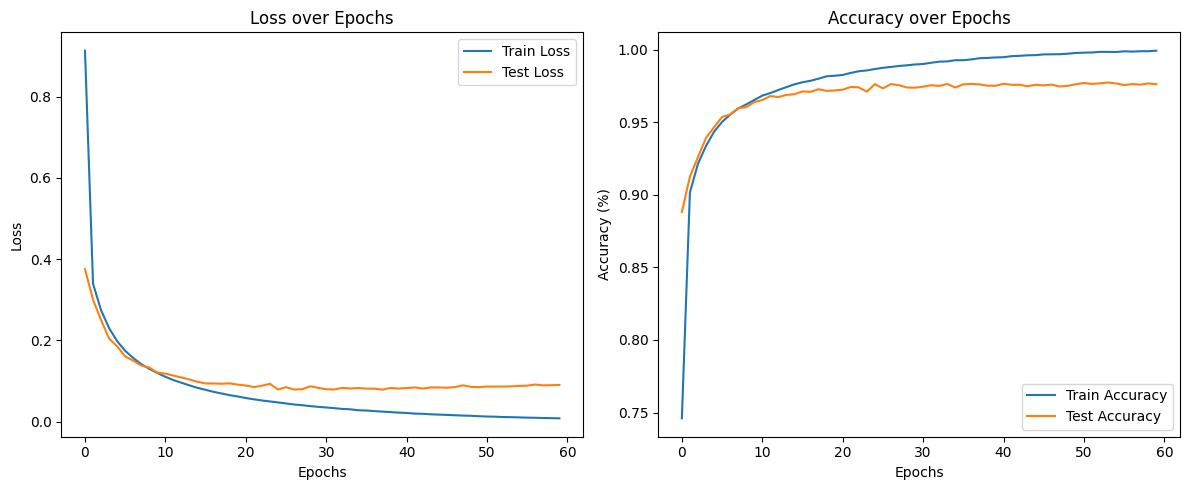

In [9]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens_list=[64,64]).to(device)
# 模型参数量
print(sum(p.numel() for p in model.parameters()))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_64_64, train_accuracy_list_64_64, test_loss_list_64_64, test_accuracy_list_64_64 = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)

show(train_loss_list_64_64, test_loss_list_64_64, train_accuracy_list_64_64, test_accuracy_list_64_64)

cuda
59210
Training on:  cuda
Epoch [1/60], Train Loss: 1.3254, Train Accuracy: 0.5806, Test Loss: 0.4434, Test Accuracy: 0.8597
Epoch [2/60], Train Loss: 0.3702, Train Accuracy: 0.8931, Test Loss: 0.3221, Test Accuracy: 0.9041
Epoch [3/60], Train Loss: 0.2932, Train Accuracy: 0.9151, Test Loss: 0.2742, Test Accuracy: 0.9158
Epoch [4/60], Train Loss: 0.2393, Train Accuracy: 0.9309, Test Loss: 0.2052, Test Accuracy: 0.9394


Epoch [5/60], Train Loss: 0.1972, Train Accuracy: 0.9429, Test Loss: 0.1835, Test Accuracy: 0.9457
Epoch [6/60], Train Loss: 0.1651, Train Accuracy: 0.9518, Test Loss: 0.1683, Test Accuracy: 0.9508
Epoch [7/60], Train Loss: 0.1438, Train Accuracy: 0.9583, Test Loss: 0.1388, Test Accuracy: 0.9610
Epoch [8/60], Train Loss: 0.1256, Train Accuracy: 0.9637, Test Loss: 0.1207, Test Accuracy: 0.9631
Epoch [9/60], Train Loss: 0.1123, Train Accuracy: 0.9676, Test Loss: 0.1233, Test Accuracy: 0.9620
Epoch [10/60], Train Loss: 0.1010, Train Accuracy: 0.9704, Test Loss: 0.1044, Test Accuracy: 0.9675
Epoch [11/60], Train Loss: 0.0916, Train Accuracy: 0.9732, Test Loss: 0.1245, Test Accuracy: 0.9633
Epoch [12/60], Train Loss: 0.0832, Train Accuracy: 0.9752, Test Loss: 0.0962, Test Accuracy: 0.9697
Epoch [13/60], Train Loss: 0.0770, Train Accuracy: 0.9772, Test Loss: 0.0940, Test Accuracy: 0.9717
Epoch [14/60], Train Loss: 0.0711, Train Accuracy: 0.9786, Test Loss: 0.0970, Test Accuracy: 0.9687
Epoch

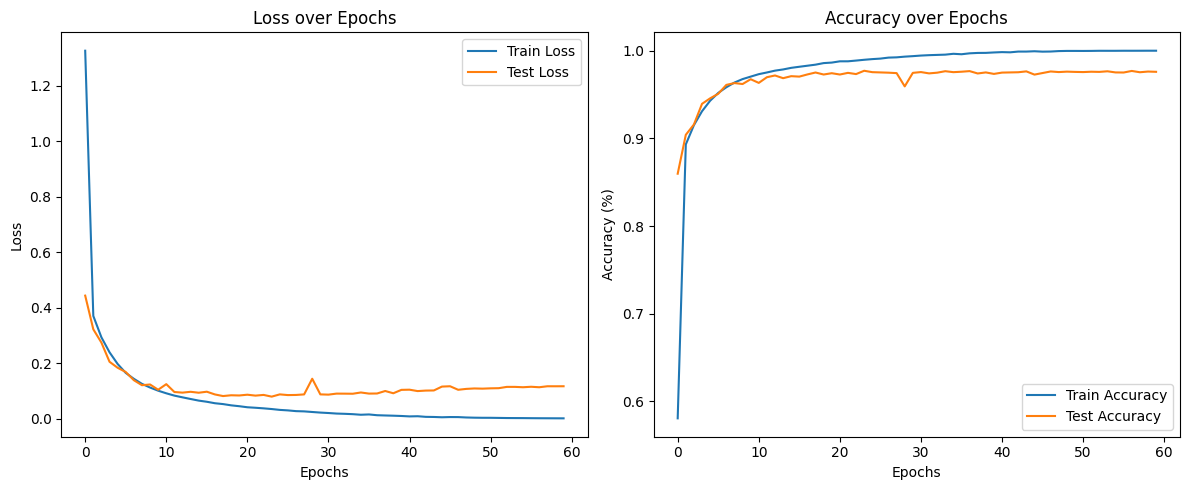

In [10]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens_list=[64,64,64]).to(device)

# 模型参数量
print(sum(p.numel() for p in model.parameters()))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_64_64_64, train_accuracy_list_64_64_64, test_loss_list_64_64_64, test_accuracy_list_64_64_64 = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)

show(train_loss_list_64_64_64, test_loss_list_64_64_64, train_accuracy_list_64_64_64, test_accuracy_list_64_64_64)

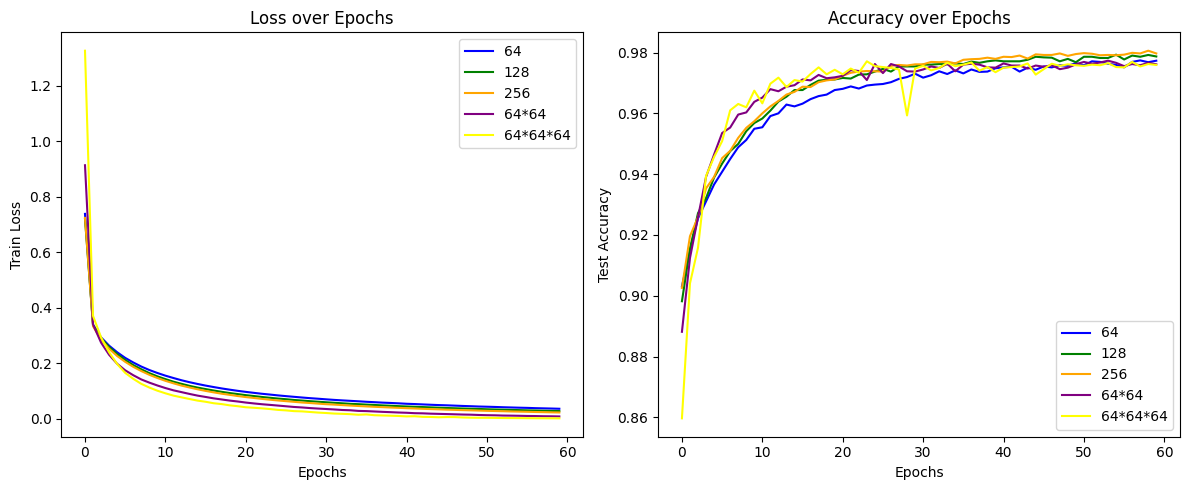

In [11]:
# 可视化结果
def show_all(train_loss_list_64, train_loss_list_128, train_loss_list_256, train_loss_list_64_64, train_loss_list_64_64_64, test_accuracy_list_64, test_accuracy_list_128, test_accuracy_list_256, test_accuracy_list_64_64, test_accuracy_list_64_64_64):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list_64, label='64', color='blue')
    plt.plot(train_loss_list_128, label='128', color='green')
    plt.plot(train_loss_list_256, label='256', color='orange')
    plt.plot(train_loss_list_64_64, label='64*64', color='purple')
    plt.plot(train_loss_list_64_64_64, label='64*64*64', color='yellow')
    plt.xlabel('Epochs')
    plt.ylabel('Train Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracy_list_64, label='64', color='blue')
    plt.plot(test_accuracy_list_128, label='128', color='green')
    plt.plot(test_accuracy_list_256, label='256', color='orange')
    plt.plot(test_accuracy_list_64_64, label='64*64', color='purple')
    plt.plot(test_accuracy_list_64_64_64, label='64*64*64', color='yellow')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
show_all(train_loss_list_64, train_loss_list_128, train_loss_list_256, train_loss_list_64_64, train_loss_list_64_64_64, test_accuracy_list_64, test_accuracy_list_128, test_accuracy_list_256, test_accuracy_list_64_64, test_accuracy_list_64_64_64)